# RAiSD Downsample check

In [2]:
library(tidyverse)
library(GenomicRanges)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The followi

# Does reduced size of rangewide sample reduce reliability of the sweep signal? 

We took advantage of the replicated Palmar Chico data. We downsampled the first of the two Palmar Chico samples to six individuals and correlated its RAiSD output with that both 10 individual population samples. 

We find that the correlation between downsampled does diminish, but only somewhat. This indicates that there is still signal for detecting sweeps when reducing the sample size to 10 individuals 

In [2]:
#sample 6 individuals and run raisd
chr <- "chr6"
chrom <- "chr6--0--181357234"
n_SAMP <- 6

In [3]:

sample_str <- paste0(sample(paste0("ind", 0:9), size = n_SAMP, replace = F), collapse = "\n")
system(str_glue("echo -e '{sample_str}' > ../playground/vcf_samples.txt"))
vcf <- str_glue("../data/angsd_vcf/v5--Teo--random1_Palmar_Chico--{chrom}.vcf.gz")
vcf
out_str <- "SUBSAMPLE"
raisd_command <- str_glue("../src/raisd-master/RAiSD -S ../playground/vcf_samples.txt -R -s -m 0.05 -n {out_str} -I {vcf} -M 2 -y 2 -w 100 -f")
raisd_command
system(raisd_command)

str_glue("{{chr}}")

../data/angsd_vcf/v5--Teo--random1_Palmar_Chico--chr6--0--181357234.vcf.gz

../src/raisd-master/RAiSD -S ../playground/vcf_samples.txt -R -s -m 0.05 -n SUBSAMPLE -I ../data/angsd_vcf/v5--Teo--random1_Palmar_Chico--chr6--0--181357234.vcf.gz -M 2 -y 2 -w 100 -f

{chr}

In [4]:
#RUN mop correction based on chromosome 
input.raisd  <- "RAiSD_Report.SUBSAMPLE.chr6"
input.bed <- str_glue("../data/mop/v5--Teo--random1_Palmar_Chico--{chrom}.bed")
output <- "RAiSD_Report.SUBSAMPLE.chr6.corrected"


In [5]:

system(str_glue("awk -v c={chr} 'BEGIN{{OFS = \"\t\"}}; NR > 1 {{print c, $2-1, $3, $0, $3-$2+1}}' {input.raisd} |\
bedtools groupby -i - -g 1,2,3,4,5,6 -c 7,8,9,10,11 -o last,last,last,last,distinct |\
bedtools intersect -a - -b {input.bed} |\
awk 'BEGIN{{OFS = \"\\t\"}};{{print $0, $3-$2}}' |\
bedtools groupby -i stdin -g 1,4,5,6 -c 7,8,9,10,11,12 -o distinct,distinct,distinct,distinct,distinct,sum |\
awk 'BEGIN{{OFS=\"\t\"}}{{varnew = ($10/$9)*$5; print $1, $2, $3, $4, varnew, $6, $7, varnew*$6*$7}}' > {output}"))


In [6]:
#load three raisd files for desired chromosome

og_teo1 <- vroom::vroom(str_glue("../data/raisd/RAiSD_Report.v5--Teo--random1_Palmar_Chico--{chrom}.corrected"),
                       delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu"))
og_teo2 <- vroom::vroom(str_glue("../data/raisd/RAiSD_Report.v5--Teo--random2_Palmar_Chico--{chrom}.corrected"),
                       delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu"))
sub_teo1 <- vroom::vroom(str_glue("{output}"),
                        delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu"))

all_raisd <- 
full_join(og_teo1, og_teo2, by = c("chrom", "pos"), suffix = c("_1", "_2")) %>% 
left_join(., sub_teo1, by = c("chrom", "pos"), suffix = c("_T", "_S")) %>% 
drop_na()

Rows: 592,172
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 702,920
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,888,313
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



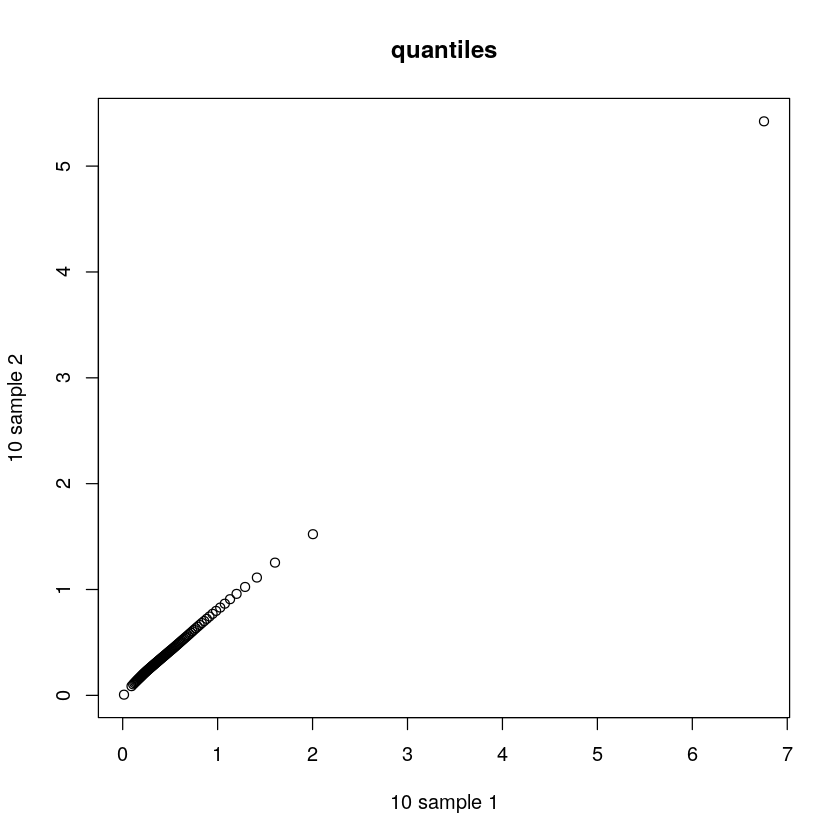


	Pearson's product-moment correlation

data:  all_raisd$mu_1 and all_raisd$mu_2
t = 251.36, df = 174348, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5122869 0.5191778
sample estimates:
      cor 
0.5157407 



	Pearson's product-moment correlation

data:  all_raisd$mu_1 and all_raisd$mu
t = 257.79, df = 174348, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5219282 0.5287253
sample estimates:
      cor 
0.5253351 



	Pearson's product-moment correlation

data:  all_raisd$mu_2 and all_raisd$mu
t = 204.57, df = 174348, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4361707 0.4437414
sample estimates:
      cor 
0.4399639 


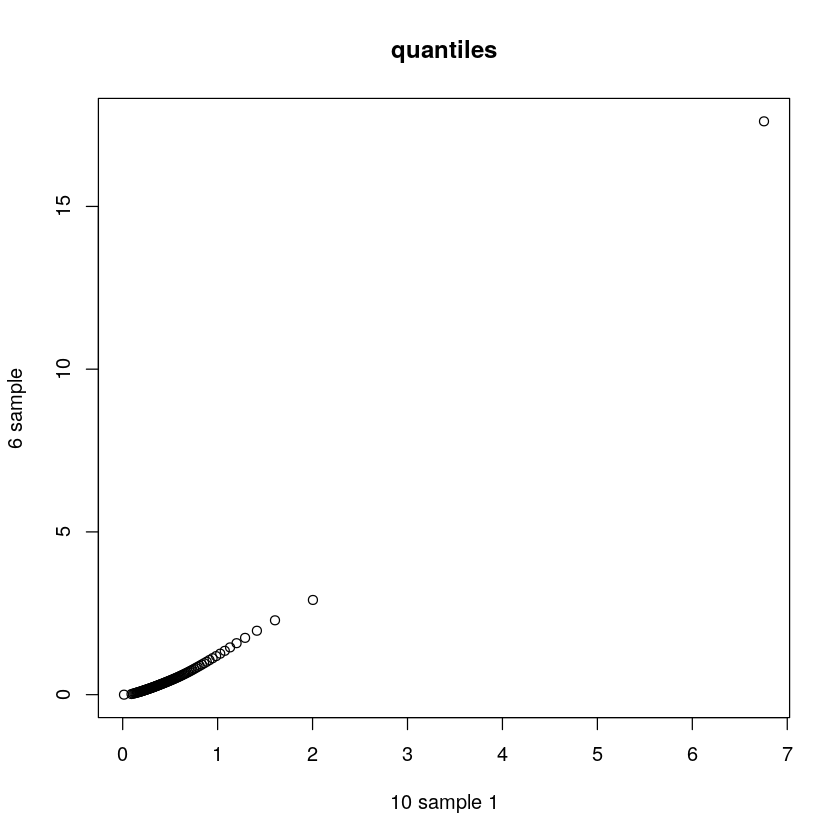

In [7]:
qs <- seq(0, 1, length.out = 100)
q1 <- quantile(og_teo1$mu, qs)
q2 <- quantile(og_teo2$mu, qs)
q3 <- quantile(sub_teo1$mu, qs)

plot(q1, q2, xlab="10 sample 1", ylab="10 sample 2", main = "quantiles")
plot(q1, q3, xlab="10 sample 1", ylab="6 sample", main = "quantiles")


cor.test(all_raisd$mu_1, all_raisd$mu_2)

cor.test(all_raisd$mu_1, all_raisd$mu)

cor.test(all_raisd$mu_2, all_raisd$mu)




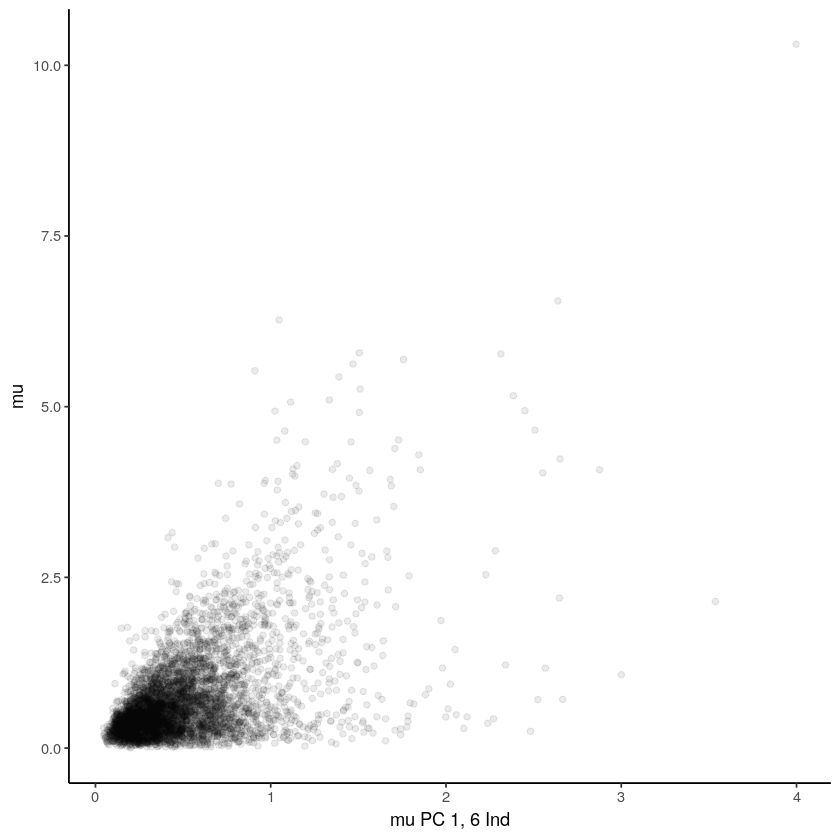

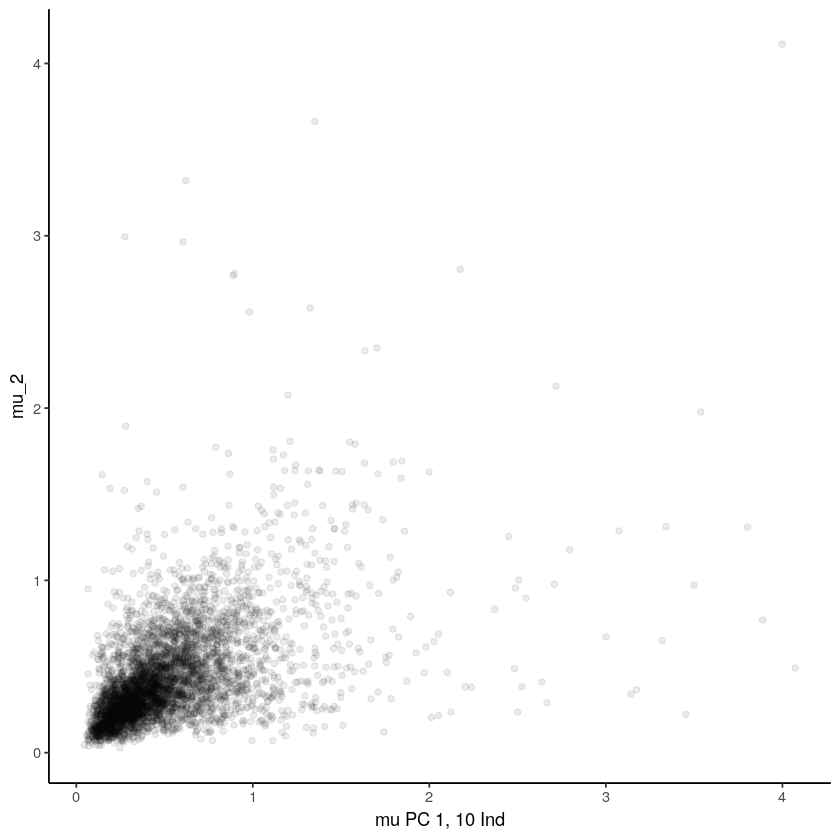

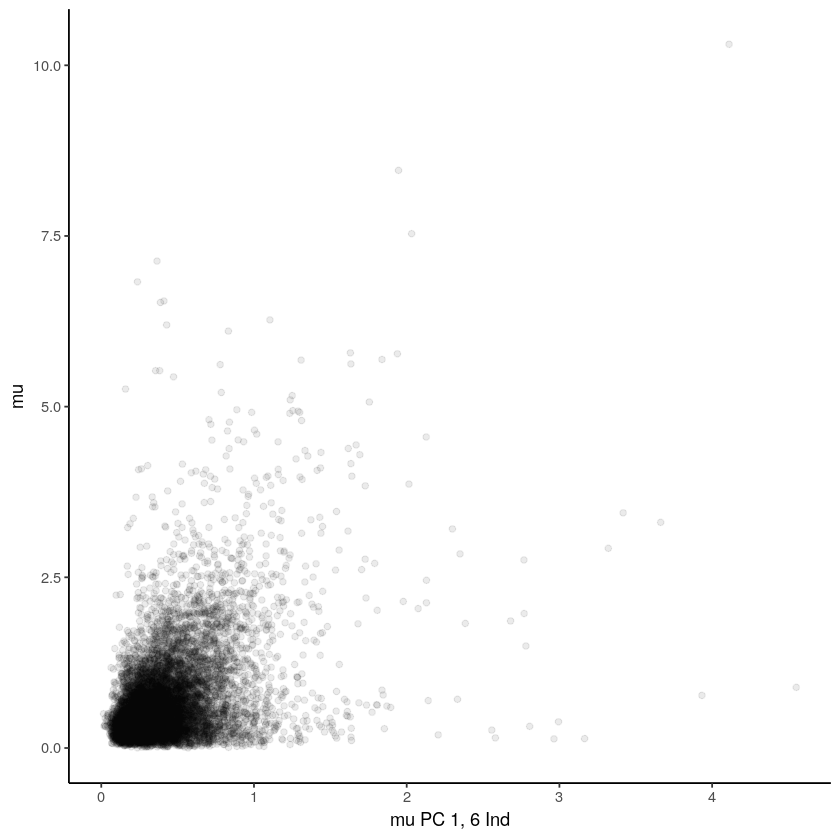

In [8]:
theme_set(theme_classic())

raisd_sample <- all_raisd %>% sample_n(10000)
alf <- 0.08
raisd_sample %>% 
    sample_n(5000) %>% 
    ggplot(aes(mu_1, mu)) +
    geom_point(alpha = alf) +
    xlab("mu PC 1, 10 Ind") +
    xlab("mu PC 1, 6 Ind")

raisd_sample %>% 
    sample_n(5000) %>% 
    ggplot(aes(mu_1, mu_2)) +
    geom_point(alpha = alf) +
    xlab("mu PC 1, 10 Ind") +
    xlab("mu PC 1, 10 Ind")


raisd_sample %>% 
    ggplot(aes(mu_2, mu)) +
    geom_point(alpha = alf) +
    xlab("mu PC 2, 10 Ind") +
    xlab("mu PC 1, 6 Ind")



# Why does rangewide have such a high proportion of private sweeps?

One possibility is that rangewide sweeps are old and drift and divergence in the individual populations has attenuated the signal. When samples are combined from multiple pops, the sweep signal is amplified moreso that it would be from any one population. If this is the case, regions where a sweep unique to the range-wide sample appears should be elevated in the individuals populations. 

We confirmed this below; Individual populations have elevated mu var statistics from raisd in regions of private rangewide sweeps.


% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Fri May 14 09:44:02 2021
\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
  \hline
population & population mean & mean at rangewide sweeps & difference \\ 
  \hline
Landrace Amatlan de Canas & 0.437 & 0.624 & 0.187 \\ 
  Landrace Crucero Lagunitas & 0.427 & 0.664 & 0.237 \\ 
  Landrace Los Guajes & 0.450 & 0.785 & 0.335 \\ 
  Landrace San Lorenzo & 0.441 & 0.765 & 0.324 \\ 
  Landrace random & 0.488 & 0.882 & 0.394 \\ 
  Landrace random1 Palmar Chico & 0.454 & 0.808 & 0.354 \\ 
  Landrace random2 Palmar Chico & 0.432 & 0.686 & 0.254 \\ 
   \hline
\end{tabular}
\end{table}


In [61]:

pop <- "data/raisd/v5--LR--random.corrected_block_outliers_merged.txt"

lr_random_unique <- vroom::vroom(
    "../data/raisd/v5--allpops--shared_outliers.txt",         
    delim = "\t",          
    col_names = c("chrom", "start", "end", "size", "populations")
) %>% 
    filter(
        chrom == "chr6", 
        size > 1, 
        populations == pop
    )

#../data/raisd/RAiSD_Report.v5--LR--Amatlan_de_Canas--chr6--0--181357234.corrected
raisd_all_df <- 
fs::dir_ls(
    path = "../data/raisd/", 
    glob = "../data/raisd/RAiSD_Report.v5--LR--*--chr6--0--181357234.corrected"
) %>% 
map_df(~{
  
    ssp_pop  <-  str_remove_all(as.character(.x), "(../data/raisd/RAiSD_Report.|--chr6--0--181357234.corrected)")
    raisd_df <- vroom::vroom(.x, col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu")) 
    
    raisd_ranges <- GRanges(raisd_df$chrom, IRanges(raisd_df$start, raisd_df$end, stat = raisd_df$mu))
    range_ranges <- GRanges(lr_random_unique$chrom, IRanges(lr_random_unique$start, lr_random_unique$end))

    hits <- findOverlaps(raisd_ranges, range_ranges)
    raisd_hits <- pintersect(raisd_ranges[queryHits(hits)], range_ranges[subjectHits(hits)]) %>%
    data.frame() %>%
    filter(hit = TRUE) %>%
    left_join(., data.frame(raisd_ranges))
    
    if(nrow(raisd_df > 0 & nrow(raisd_hits) > 0)){
    bind_rows(
    tibble(mu = raisd_df$mu, population = ssp_pop, type = "genomewide"),
    tibble(mu = raisd_hits$stat, population = ssp_pop, type = "rangewide")
    )
    } else{
        tibble()
    }
    })

#Does var in individual pops tend to be higher in regions of rangewide sweeps?



Rows: 3,699
Columns: 5
Delimiter: "\t"
chr [2]: chrom, populations
dbl [3]: start, end, size

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 680,908
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Joining, by = c("seqnames", "start", "end", "width", "strand", "stat")

Rows: 686,969
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Joining, by = c("seqnames", "start", "end", "width", "strand", "stat")

Rows: 631,871
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specifi

Saving 6.67 x 6.67 in image

Picking joint bandwidth of 0.167

Picking joint bandwidth of 0.171

Picking joint bandwidth of 0.163

Picking joint bandwidth of 0.175

Picking joint bandwidth of 0.293

Picking joint bandwidth of 0.181



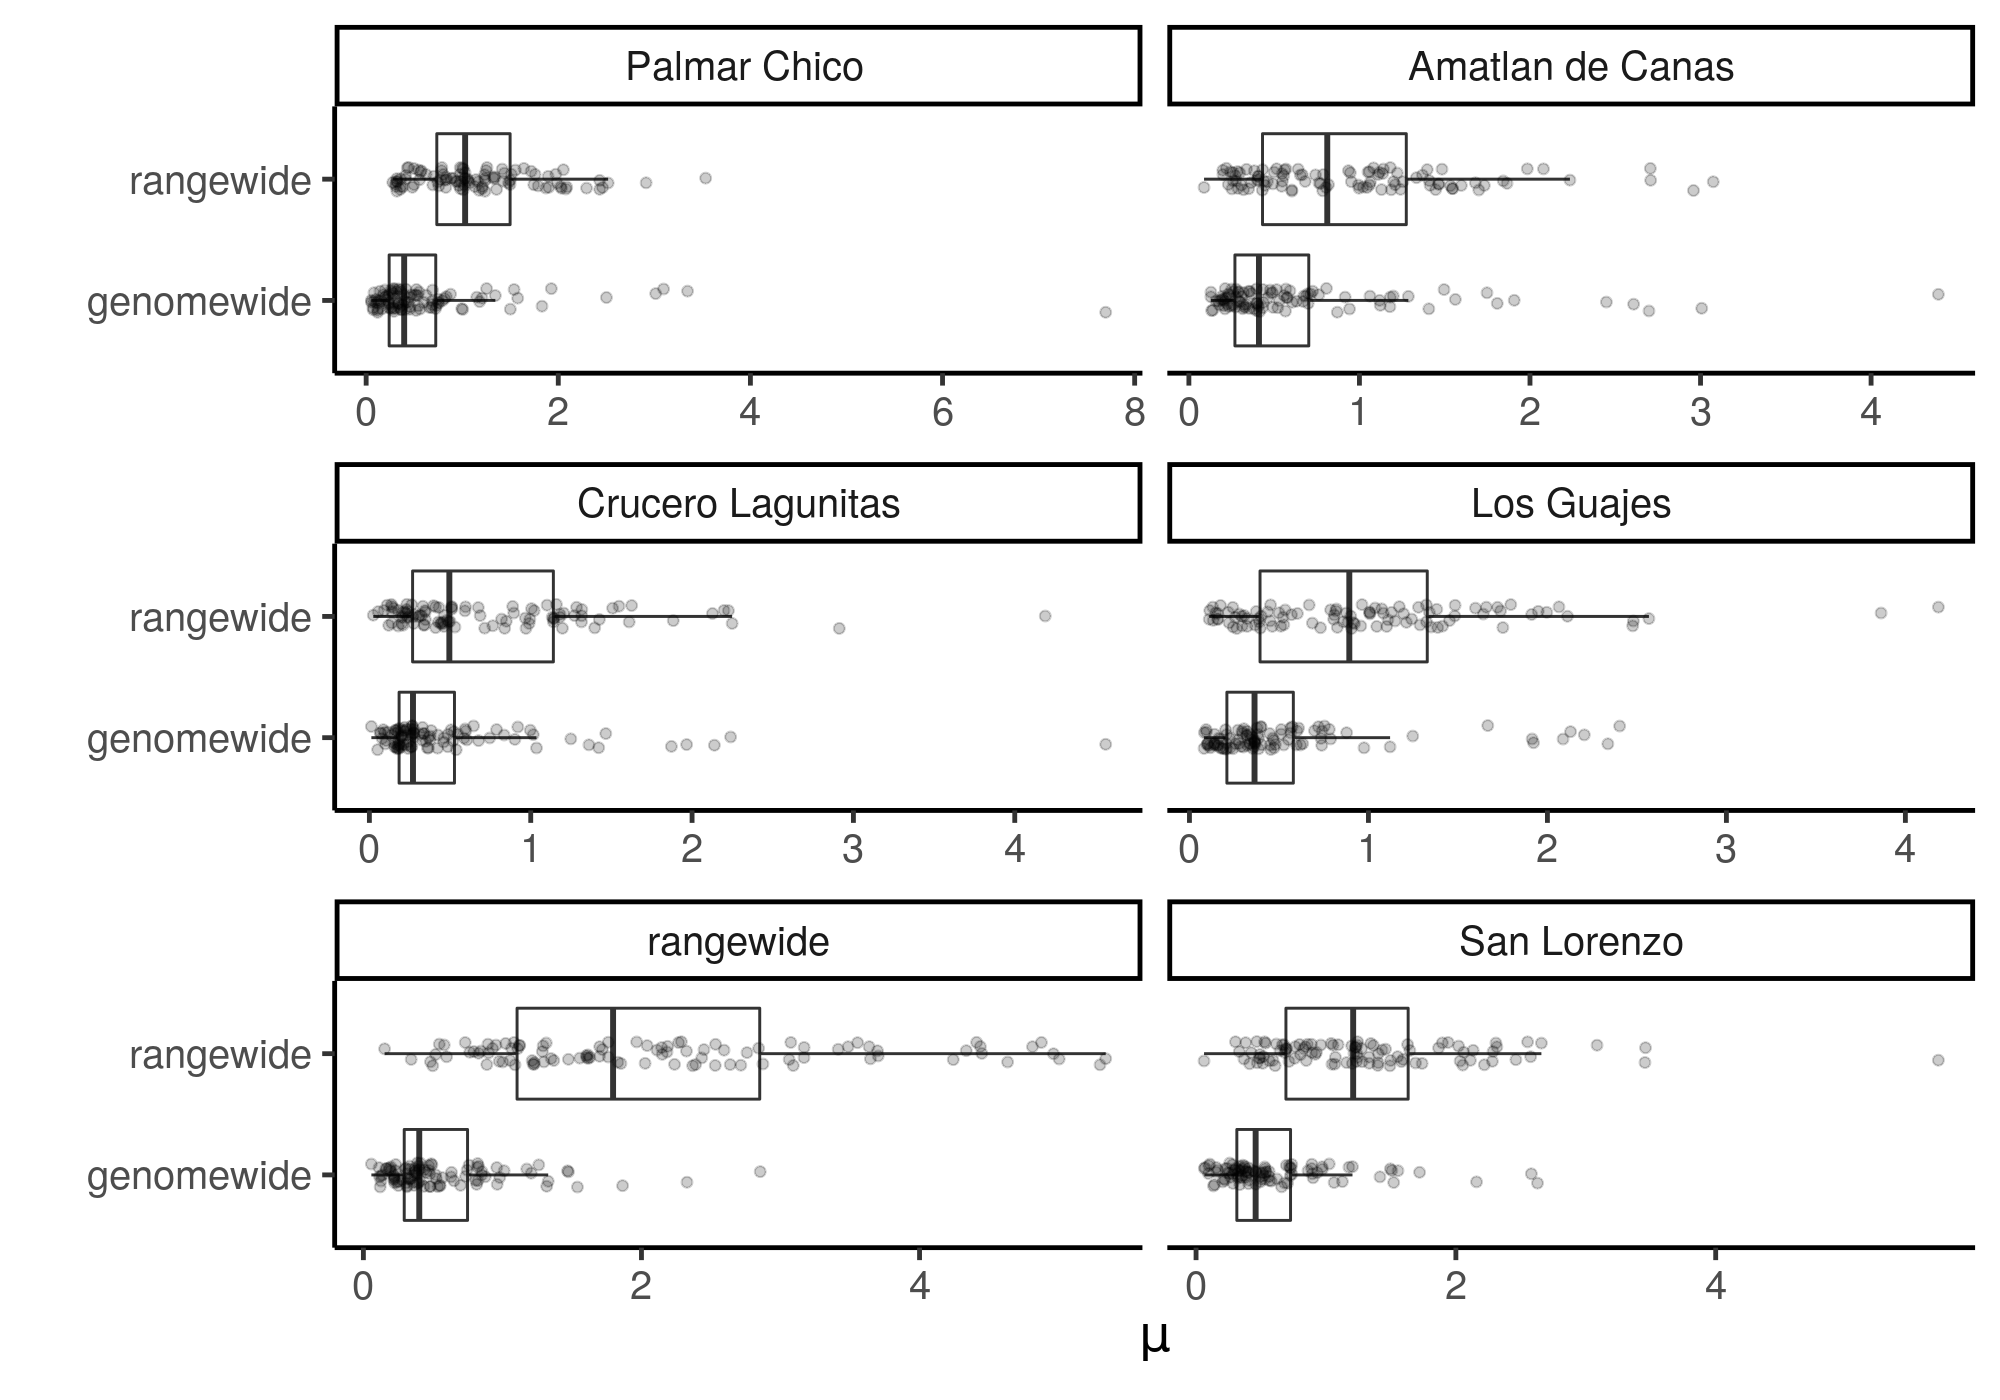

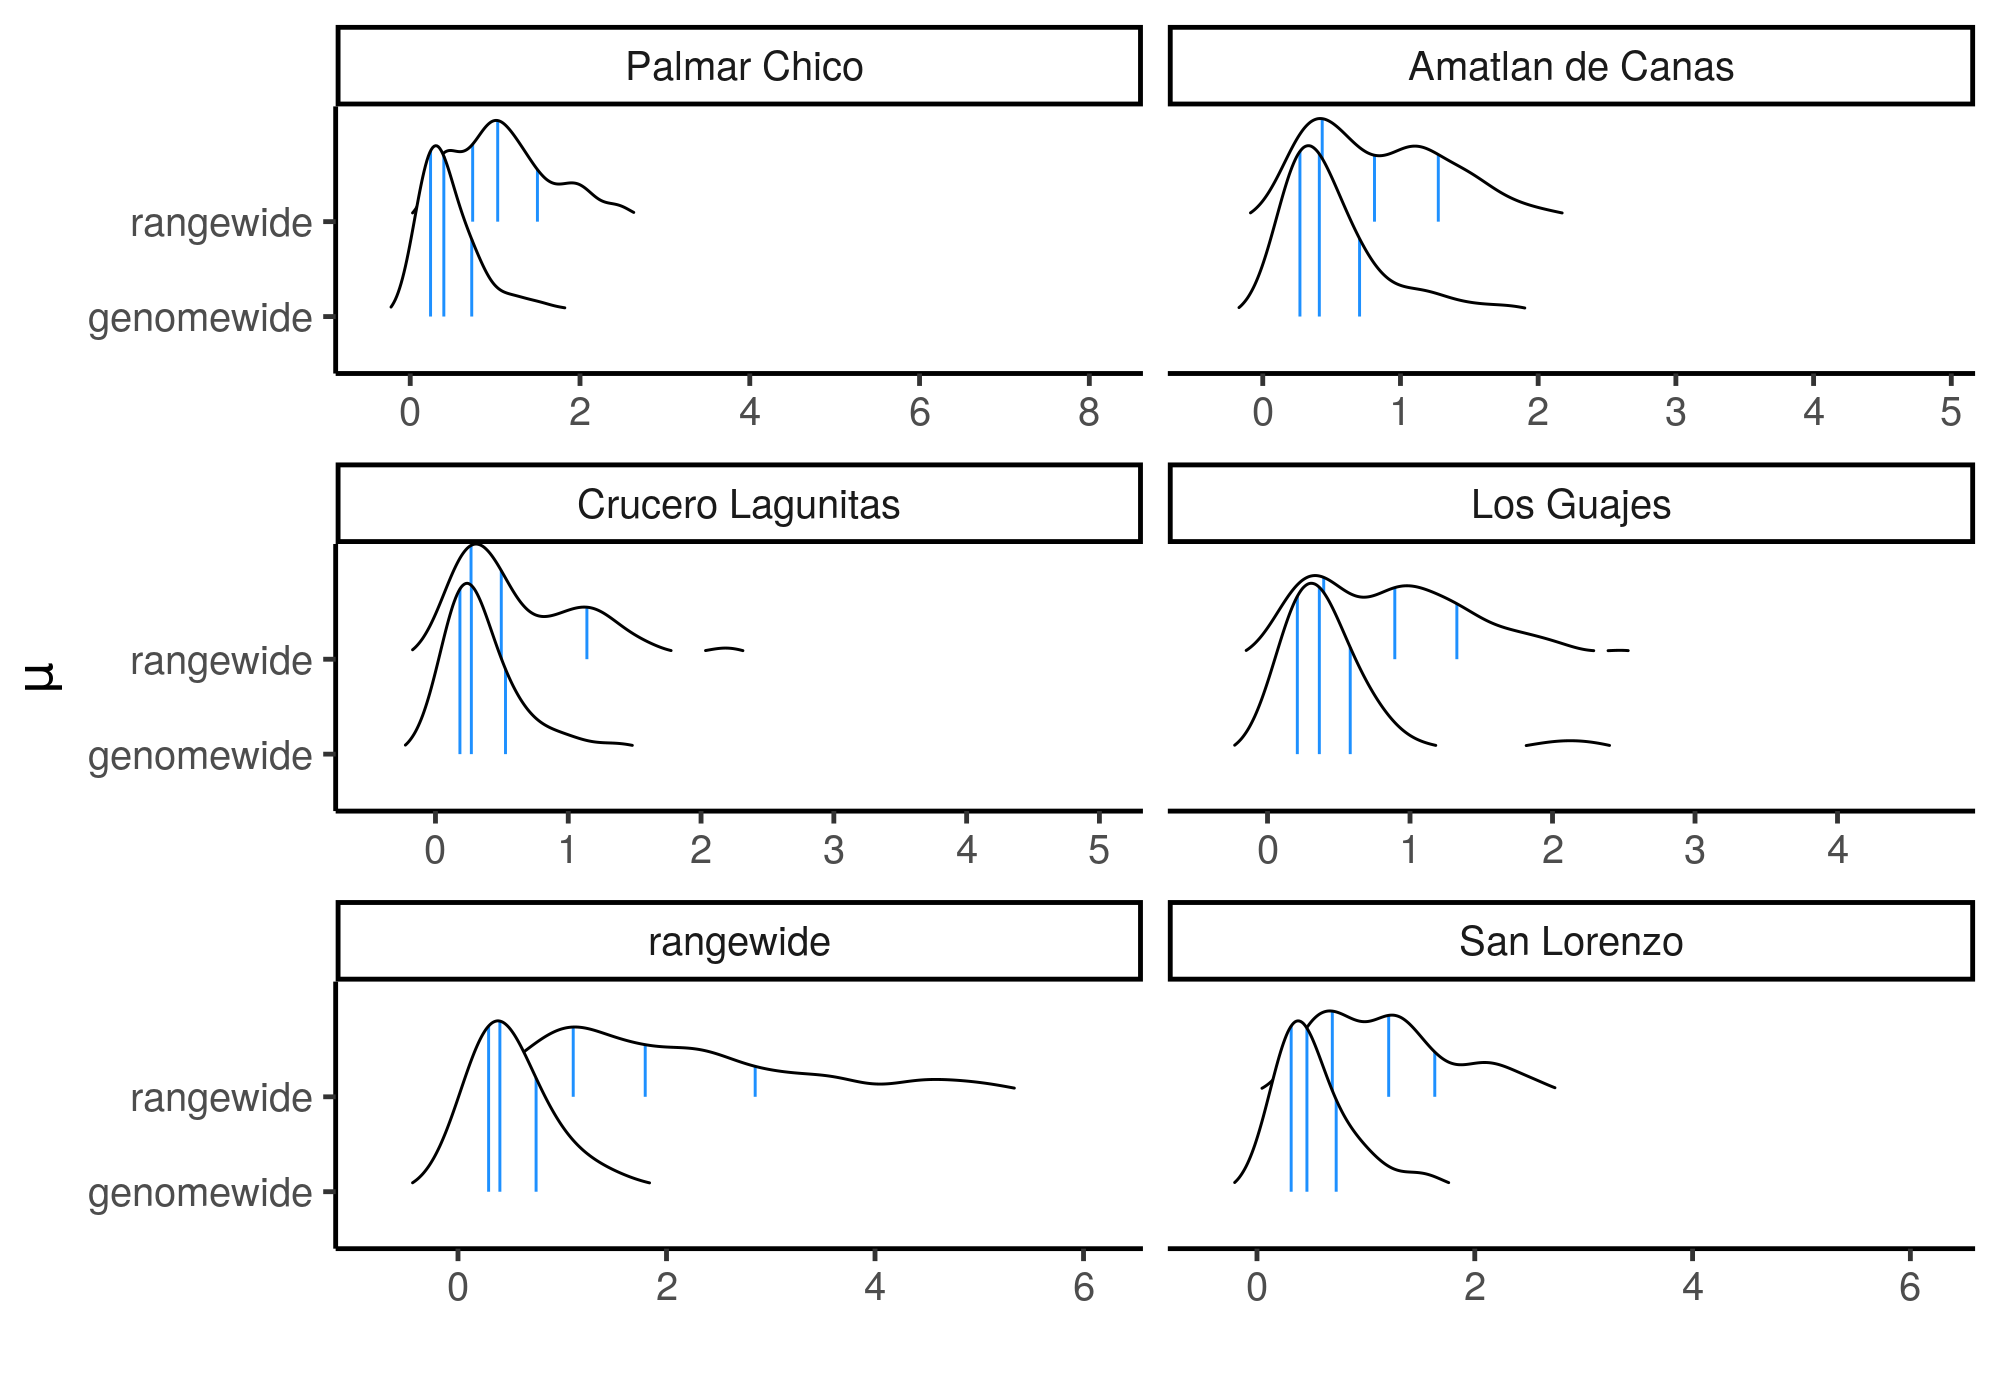

In [68]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

sample_df <- 
    raisd_all_df %>%
    group_by(population, type) %>% 
    sample_n(100) %>% 
    filter(population != "v5--LR--random2_Palmar_Chico") %>% 
    mutate(population = str_replace_all(population, "v5--LR--", "")) %>%
    mutate(population = str_replace_all(population, "_", " ")) %>%
    mutate(population = str_replace_all(population, "random1", "")) %>%
    mutate(population = str_replace_all(population, "random", "rangewide"))

sample_df %>%
    ggplot(aes(type, mu)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(height = 0, width = 0.1, alpha = 0.2) +
    facet_wrap(~population, ncol = 2, scales = "free_x") +
    xlab("") +
    ylab(expression(mu)) +
    theme_classic(18) +
    coord_flip() +
    ggsave("../figures/supplement_rangewidesweeps.pdf")

library(ggridges)
sample_df %>%
    ggplot(aes(mu, type)) +
    ggridges::geom_density_ridges(
        rel_min_height = 0.05, 
        quantile_lines = TRUE, fill = "white",
        vline_color = "dodgerblue") +
    facet_wrap(~population, ncol = 2, scales = "free_x") +
    xlab("") +
    ylab(expression(mu)) +
    theme_classic(18)